<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_%F0%9F%92%BB_Python_PyTorch_Training_JST_Sederhana_(FashionMNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💻 Python/PyTorch Training JST Sederhana (FashionMNIST)

### Cell 1: Setup dan Import Library

Mengimpor semua *library* yang diperlukan dan menetapkan *seed* untuk memastikan hasil yang **reproduktif**.


In [1]:
# ==============================================================================
# JST Sederhana: Training, Validation, dan Testing
# Framework: PyTorch
# ==============================================================================

# Import Library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Tetapkan seed untuk reproduktifitas
torch.manual_seed(42)
print("Library berhasil diimpor dan seed telah ditetapkan.")

Library berhasil diimpor dan seed telah ditetapkan.


### Cell 2: Konfigurasi Hyperparameter dan Perangkat

Menetapkan *hyperparameter* kunci seperti **Batch Size** dan **Epoch**, serta menentukan apakah pelatihan akan menggunakan **GPU (CUDA)** atau **CPU**.

In [2]:
# Konfigurasi Hyperparameter
BATCH_SIZE = 64     # Jumlah sampel per iterasi (penting untuk efisiensi)
NUM_EPOCHS = 20     # Jumlah siklus penuh melalui seluruh dataset
LEARNING_RATE = 0.001 # Learning Rate (Laju Pembelajaran)
NUM_CLASSES = 10    # Jumlah kelas FashionMNIST
INPUT_SIZE = 28 * 28 # Ukuran gambar (784 piksel)

# Tentukan perangkat (GPU jika tersedia, jika tidak CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")
print(f"Hyperparameter telah dikonfigurasi: Batch Size={BATCH_SIZE}, Epochs={NUM_EPOCHS}, LR={LEARNING_RATE}")

Menggunakan perangkat: cuda
Hyperparameter telah dikonfigurasi: Batch Size=64, Epochs=20, LR=0.001


### Cell 3: Memuat dan Mempersiapkan Data

Memuat **FashionMNIST**, menerapkan **Transformasi**, dan membagi data pelatihan menjadi **Training Set** dan **Validation Set** untuk memantau *generalisasi*.

In [3]:
# Definisikan transformasi: Mengubah gambar menjadi Tensor dan normalisasi
transform = transforms.Compose([
    transforms.ToTensor(), # Mengubah gambar (PIL Image) ke Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalisasi
])

# Memuat dataset FashionMNIST
full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Memisahkan Dataset Pelatihan menjadi Training (80%) dan Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total Sampel: {len(full_dataset)}")
print(f"Dataset Pelatihan: {len(train_dataset)}, Dataset Validasi: {len(val_dataset)}, Dataset Testing: {len(test_dataset)}")

# Membuat DataLoader untuk Training, Validation, dan Testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoader untuk Training, Validation, dan Testing berhasil dibuat.")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]

Total Sampel: 60000
Dataset Pelatihan: 48000, Dataset Validasi: 12000, Dataset Testing: 10000
DataLoader untuk Training, Validation, dan Testing berhasil dibuat.


### Cell 4: Mendefinisikan Arsitektur JST Sederhana (Model)

Mendefinisikan arsitektur JST (Multi-Layer Perceptron / MLP) yang akan digunakan untuk klasifikasi 10 kelas.


In [4]:
# JST (Multi-Layer Perceptron / MLP) dengan 3 lapisan linear
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLP, self).__init__()
        # Lapisan 1: 784 (input) -> 512 (hidden)
        self.fc1 = nn.Linear(input_size, 512)
        # Lapisan 2: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        # Lapisan Output: 256 -> 10 (jumlah kelas)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU() # Fungsi aktivasi ReLU

    def forward(self, x):
        # Flatten input (28x28) menjadi vektor 784
        x = x.view(-1, INPUT_SIZE)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inisialisasi model dan memindahkannya ke DEVICE
model = SimpleMLP(INPUT_SIZE, NUM_CLASSES).to(DEVICE)

# Loss Function: Cross Entropy Loss (Wajib untuk Klasifikasi Multi-Kelas)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Arsitektur Model, Loss Function, dan Optimizer telah ditetapkan.")

Arsitektur Model, Loss Function, dan Optimizer telah ditetapkan.


### Cell 5: Fungsi Akurasi dan Persiapan Loop

Mendefinisikan fungsi pembantu untuk menghitung akurasi, yang akan digunakan selama fase validasi dan *testing*.

In [5]:
# Fungsi untuk menghitung akurasi model pada DataLoader manapun
def calculate_accuracy(loader, model):
    model.eval() # Mode evaluasi (penting!)
    correct = 0
    total = 0
    with torch.no_grad(): # Tidak perlu gradien
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Ambil prediksi (kelas dengan skor tertinggi)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# List untuk menyimpan sejarah Loss dan Akurasi (untuk visualisasi)
train_losses = []
val_losses = []
val_accuracies = []

print("Fungsi 'calculate_accuracy' siap digunakan.")

Fungsi 'calculate_accuracy' siap digunakan.


### Cell 6: Siklus Pelatihan dan Validasi (Main Loop)

Ini adalah *cell* utama yang menjalankan siklus **Epoch** dan melakukan fase **Training** serta **Validation** di setiap *epoch* untuk memonitor **Overfitting**.

In [6]:
print("Memulai Siklus Pelatihan dan Validasi...")
for epoch in range(NUM_EPOCHS):
    model.train() # Mode pelatihan
    running_loss = 0.0

    # --- TRAINING PHASE ---
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad() # 1. Reset gradien

        outputs = model(images) # 2. Forward pass
        loss = criterion(outputs, labels) # 3. Hitung Loss

        loss.backward() # 4. Backward pass (hitung gradien)
        optimizer.step() # 5. Update Bobot (Gradient Descent)

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    # Hitung Akurasi Validasi
    val_acc = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_acc)

    # Cetak status (memantau konvergensi)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] '
          f'| Training Loss: {train_loss:.4f} '
          f'| Validation Loss: {val_loss:.4f} '
          f'| Validation Accuracy: {val_acc:.2f}%')

print("Pelatihan Selesai!")

Memulai Siklus Pelatihan dan Validasi...
Epoch [1/20] | Training Loss: 0.5039 | Validation Loss: 0.4202 | Validation Accuracy: 85.17%
Epoch [2/20] | Training Loss: 0.3788 | Validation Loss: 0.3757 | Validation Accuracy: 86.38%
Epoch [3/20] | Training Loss: 0.3360 | Validation Loss: 0.3546 | Validation Accuracy: 87.21%
Epoch [4/20] | Training Loss: 0.3093 | Validation Loss: 0.3525 | Validation Accuracy: 87.50%
Epoch [5/20] | Training Loss: 0.2870 | Validation Loss: 0.3463 | Validation Accuracy: 88.01%
Epoch [6/20] | Training Loss: 0.2685 | Validation Loss: 0.3227 | Validation Accuracy: 88.16%
Epoch [7/20] | Training Loss: 0.2527 | Validation Loss: 0.3364 | Validation Accuracy: 88.39%
Epoch [8/20] | Training Loss: 0.2388 | Validation Loss: 0.3537 | Validation Accuracy: 87.78%
Epoch [9/20] | Training Loss: 0.2223 | Validation Loss: 0.3225 | Validation Accuracy: 89.03%
Epoch [10/20] | Training Loss: 0.2154 | Validation Loss: 0.3318 | Validation Accuracy: 88.69%
Epoch [11/20] | Training Los

### Cell 7: Visualisasi Kurva Konvergensi

Memvisualisasikan *Training Loss* dan *Validation Loss* untuk menentukan apakah model telah **konvergen** atau mengalami **Overfitting**.

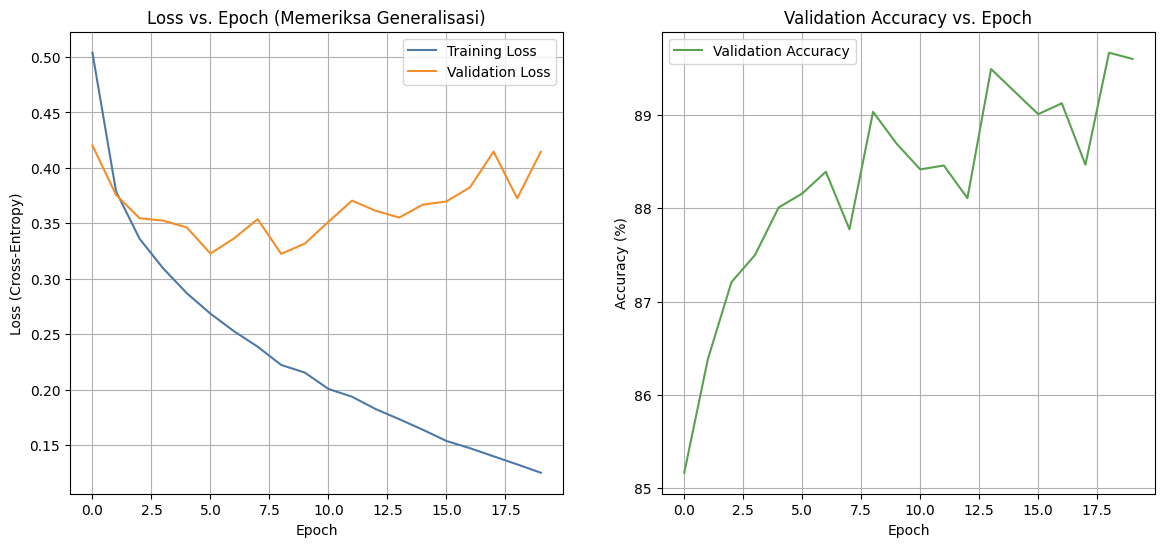

In [7]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='#4e79a7')
plt.plot(val_losses, label='Validation Loss', color='#f28e2b')
plt.title('Loss vs. Epoch (Memeriksa Generalisasi)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)

# Plot Akurasi Validasi
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='#59a14f')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

### Cell 8: Siklus Testing (Evaluasi Akhir)

Fase evaluasi akhir yang dilakukan **sekali** pada **Test Set** yang benar-benar terpisah untuk mendapatkan estimasi **Generalisasi** yang objektif.

In [8]:
# Memastikan model dalam mode evaluasi
model.eval()

print("\nMemulai Siklus Testing (Evaluasi Akhir)...")
# Hitung akurasi pada data testing
final_test_accuracy = calculate_accuracy(test_loader, model)
print(f'======================================================')
print(f'Akurasi Akhir pada Dataset Testing (Generalisasi): {final_test_accuracy:.2f}%')
print(f'======================================================')

# Catatan: Akurasi Testing adalah metrik yang dilaporkan dalam penelitian Anda.


Memulai Siklus Testing (Evaluasi Akhir)...
Akurasi Akhir pada Dataset Testing (Generalisasi): 88.94%
